# Analyse der MoWaS-Meldungen an NINA V2.0
Motiviert durch den [bundesweiten Warntag 2020](https://warnung-der-bevoelkerung.de/) kam die Idee auf, zu analysieren, welche Meldungen durch [MoWaS](https://www.bbk.bund.de/DE/AufgabenundAusstattung/Krisenmanagement/WarnungderBevoelkerung/MoWaS/ModularesWarnsystem_node.html) (Modulares Warnsystem) an die Warn-App [NINA](https://www.bbk.bund.de/DE/NINA/Warn-App_NINA_node.html) gesendet wurden. Eine erste Analyse wurden basierend auf Daten vom Bundesamt für Bevölkerungsschutz und Katastrophenhilfe (PDF-Datei mit Warnmeldungen zwischen 2014 und 2017, Datei aus einer [Anfrage](https://fragdenstaat.de/anfrage/ubersicht-uber-warnmeldungen-des-bevolkerungsschutzes-mithilfe-der-app-nina/)) durchgeführt.

Ganz frisch wurden durch das Bundesamt für Bevölkerungsschutz und Katastrophenhilfe neue Daten zur Verfügung gestellt. Die Daten umfassen die Jahre 2015 - 2020 und sind auf [FragDenStaat](https://fragdenstaat.de/anfrage/warnmeldungen-uber-die-warn-app-nina/) frei zugänglich. Diese neuen Daten sollen hier nun analysiert werden.

### Import der benötigten Module

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import folium
from folium import plugins

from sklearn.feature_extraction.text import CountVectorizer

### Datenimport
Alle Sheets der Excel-Datei werden in ein Dictionary geladen.

In [2]:
df_sheet_map = pd.read_excel("../data/Warnmeldungen.xls", sheet_name=None,dtype={"Datum":str})

Insgesamt wurden acht Sheets eingelesen.

In [3]:
df_sheet_map.keys()

dict_keys(['2015', '2016', '2017', '2018', '2019', '2020', 'Tabelle2', 'Tabelle1'])

Zwei davon enthalten keine Daten und können deshalb entfernt werden.

In [4]:
df_sheet_map.pop("Tabelle2")
df_sheet_map.pop("Tabelle1")

""


Alle Sheets können nun in einem Pandas DataFrame zusammengepackt werden.

In [5]:
df = pd.concat(df_sheet_map)

Der Sheetname ist der Index im DataFrame. Wir setzen den Index zurück und benennen die Spalte neu.

In [6]:
df = df.reset_index()

df.drop("level_1",axis=1,inplace=True)
df.rename(columns={"level_0" : "Jahr"},inplace=True)

Der DateFrame enthält ingesamt neun Spalten.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3546 entries, 0 to 3545
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Jahr            3546 non-null   object
 1   Datum           3546 non-null   object
 2   Station         3546 non-null   object
 3   Warnstufe       3541 non-null   object
 4   App             14 non-null     object
 5   Anlass          3546 non-null   object
 6   Land            3387 non-null   object
 7   Aktualisierung  353 non-null    object
 8   Kategorie       2164 non-null   object
dtypes: object(9)
memory usage: 249.5+ KB


Die Spalte *App* enthält nur 14 Einträge ungleich Null. Deshalb wird die Spalte entfernt.

In [8]:
df.drop(["App", "Aktualisierung"],axis=1,inplace=True)

### Datenaufbereitung

In [9]:
df.head()

,Jahr,Datum,Station,Warnstufe,Anlass,Land,Kategorie
0,2015,2015-06-12 00:00:00,Warnzentrale,"3, niedrig",Unwetter,NaN,NaN
1,2015,2015-07-25 00:00:00,ZSVerbSt KA,"2, mittel",Unwetter,NaN,NaN
2,2015,2015-08-10 00:00:00,Düsseldorf,"3, niedrig",Bombenentschärfung,NaN,NaN
3,2015,2015-08-12 00:00:00,Düsseldorf,"3, niedrig",Bombenentschärfung,NaN,NaN
4,2015,2015-08-25 00:00:00,Kleve,"3, niedrig",Bombenentschärfung,NaN,NaN


Die Spalte *Warnstufe* enthält die Bezeichnung der Warnstufe und eine numerische Kodierung. Wir treffen die Information auf in zwei separate Spalten:

In [10]:
df[["Warnstufe", "Warnstufe_Bezeichnung"]] =  df["Warnstufe"].str.split(",",expand=True)

Die Spalte *Datum* enthält Einträge mit unterschiedlichen Syntaxen. Es existieren Einträge wie "2015-06-12" mit Angabe des Jahres, aber auch Einträge der Art "30.06." In letzterem Fall muss die Information zum Jahr aus der Spalte *Jahr* extrahiert werden, welche aus dem Name des Excel-Sheets generiert wurde, aus welchem die jeweiligen Daten stammen.

In [11]:
df["Datum"].unique()

array(['2015-06-12 00:00:00', '2015-07-25 00:00:00',
       '2015-08-10 00:00:00', '2015-08-12 00:00:00',
       '2015-08-25 00:00:00', '2015-09-09 00:00:00',
       '2015-09-30 00:00:00', '2015-11-02 00:00:00',
       '2015-11-06 00:00:00', '2015-11-13 00:00:00',
       '2015-11-30 00:00:00', '2015-12-04 00:00:00',
       '2015-12-31 00:00:00', '2016-01-08 00:00:00',
       '2016-01-12 00:00:00', '2016-01-14 00:00:00',
       '2016-01-21 00:00:00', '2016-02-02 00:00:00',
       '2016-02-03 00:00:00', '2016-02-11 00:00:00',
       '2016-02-16 00:00:00', '2016-02-18 00:00:00',
       '2016-02-25 00:00:00', '2016-02-26 00:00:00',
       '2016-03-01 00:00:00', '2016-03-02 00:00:00',
       '2016-03-03 00:00:00', '2016-04-02 00:00:00',
       '2016-04-07 00:00:00', '2016-04-13 00:00:00',
       '2016-04-14 00:00:00', '2016-04-27 00:00:00',
       '2016-04-29 00:00:00', '2016-05-02 00:00:00',
       '2016-05-04 00:00:00', '2016-05-11 00:00:00',
       '2016-05-12 00:00:00', '2016-05-31 00:0

Um aus den unterschiedlich strukturierten Datumsinformationen für jede Warnmeldung das tatsächliche Datum zu konstruieren, wird folgende Methode benutzt. Ist das Datum schon im passenden Format, wird aus dem String direkt ein Pandas Timestamp erstellt. Falls das Jahr fehlt, wird ein neuer Datums-String gebaut und dann umgewandelt.

In [12]:
def constructDate(row):
    datum = row["Datum"]
    jahr = row["Jahr"]
    
    if "-" in datum and len(datum.split("-")) == 3:
        return pd.to_datetime(datum)
    else:
        split = datum.split(".")
        tmp = jahr + "-" + split[1] + "-" + split[0]
        try:
            out = pd.to_datetime(tmp)
            return out
        except:
            return None
         

In [13]:
df["Datum"] = df.apply(constructDate,axis=1)

Zeilen, für welche auf die oben beschriebene Art kein Datum gebildet werden konnte, werden gedroppt.

In [14]:
df.dropna(subset=["Datum"],inplace=True)

Die beiden Spalten *Warnstufe* und *Jahr* werden zu numerischen Spalten umgewandelt.

In [15]:
df["Warnstufe"] = pd.to_numeric(df["Warnstufe"])
df["Jahr"] = pd.to_numeric(df["Jahr"])

Zum Überprüfen der Umwandlung des Datums schauen wir uns an, ob das Jahr des erzeugten Datums mit dem Datenjahr (Excel-Sheetname) übereinstimmt. In einem Fall ist dies nicht so:

In [16]:
df[df["Datum"].dt.year != df["Jahr"]]

,Jahr,Datum,Station,Warnstufe,Anlass,Land,Kategorie,Warnstufe_Bezeichnung
246,2017,2014-04-08,"Kreis Düren, Amt f. Bev.-schutz S054",3.0,kreisweiter Sirenenprobealarm im Kreis Düren,NRW,NaN,niedrig


Diese eine Zeile wird aus der Analyse ausgeklammert.

In [17]:
df = df[df["Datum"].dt.year == df["Jahr"]]

Wir fügen basierend auf dem Datum noch den Monat sowie den Wochentag hinzu:

In [18]:
df["Monat"] = df["Datum"].dt.month
df["Wochentag"] = df["Datum"].dt.weekday
df["Wochentag_Text"] = df["Datum"].dt.day_name(locale ='de_DE.utf8')

In den Daten sind auch Tippfehler, die verbessert werden:

In [19]:
df["Station"] = df["Station"].str.replace("Dortmumd", "Dortmund")
df["Station"] = df["Station"].str.replace("Mühlhein", "Mühlheim")

Bis auf die Spalte *Kategorie* sind nun alle Zeilen annährend vollständig gefüllt.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3537 entries, 0 to 3545
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Jahr                   3537 non-null   int64         
 1   Datum                  3537 non-null   datetime64[ns]
 2   Station                3537 non-null   object        
 3   Warnstufe              3532 non-null   float64       
 4   Anlass                 3537 non-null   object        
 5   Land                   3379 non-null   object        
 6   Kategorie              2158 non-null   object        
 7   Warnstufe_Bezeichnung  3532 non-null   object        
 8   Monat                  3537 non-null   int64         
 9   Wochentag              3537 non-null   int64         
 10  Wochentag_Text         3537 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 331.6+ KB


## Analysen

### Meldungen pro Jahr
Die Einträge sind über die Jahre nicht gleichverteilt. Die ersten drei Jahre entsprechen aggregiert ungefähr dem Jahr 2018. Eine Erklärung hierfür ist, dass Unwetterwarnungen des Deutschen Wetterdienstes erst ab 2018 über MoWaS verteilt werden.

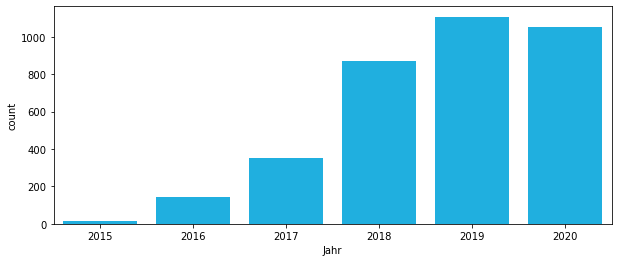

In [21]:
plt.figure(figsize=(10,4))
sns.countplot(x="Jahr",data=df,color = "deepskyblue")

### Meldungen pro Monat
Vor allem in den letzten drei Jahren sind saisonale Schwankungen erkennbar.

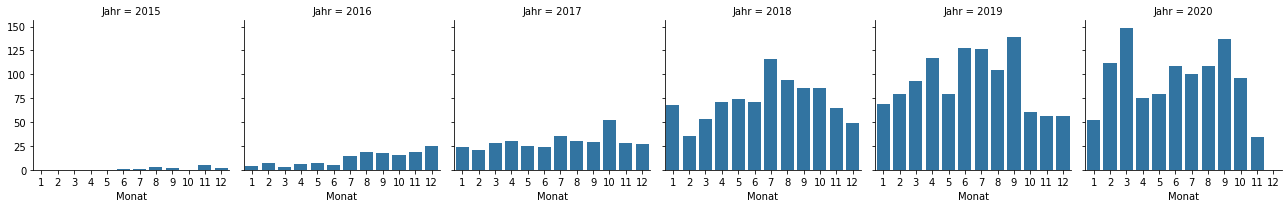

In [22]:
g = sns.FacetGrid(data=df, col="Jahr")
g.map(sns.countplot,"Monat",order=sorted(df["Monat"].unique()))

### Meldungen pro Wochentag
Der Wochentag 0 entspricht einem Montag, 6 einem Sonntag. Über alle Jahre hinweg wurden sonntags die wenigsten Meldungen verschickt. Bis auf das Jahr 2020 ist Donnerstag (Tag 3) der häufigste Tag der Woche.

/home/denis/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


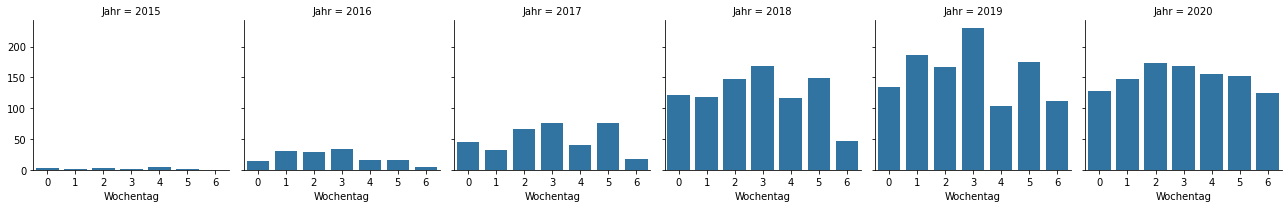

In [23]:
g = sns.FacetGrid(data=df, col="Jahr")
g.map(sns.countplot,"Wochentag")

### Meldungen pro Bundesland

In [273]:
per_bundesland = pd.DataFrame(df.groupby(["Jahr","Land"]).count()["Datum"] / df.groupby("Jahr").count()["Warnstufe"]).reset_index().rename(columns = {0 : "Anteil"})

NRW sendet in allen Jahren anteilsmäßig die meisten Warnmeldungen aus. 

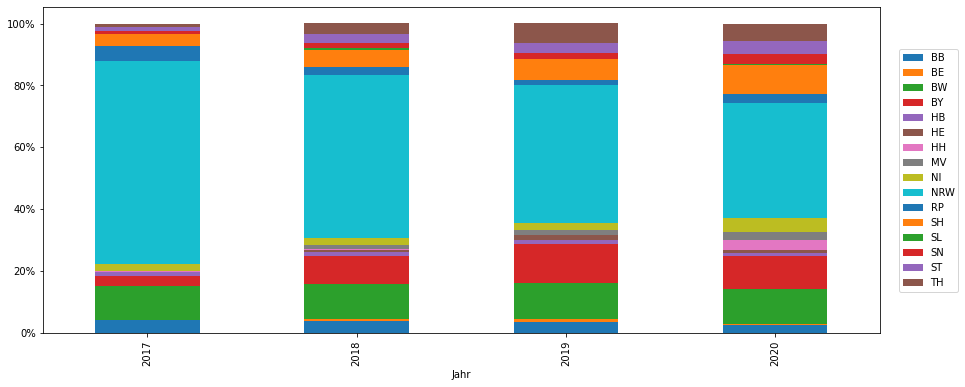

In [289]:
ax = per_bundesland.pivot("Jahr","Land","Anteil").plot(kind="bar",stacked=True,figsize=(15,6))
y = ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
l = plt.legend(loc='right',bbox_to_anchor=(0.5, 0.25, 0.6, 0.5))

### Auslösende Stellen


Die Berufsfeuerwehr in Reutlingen löst sehr oft eine Warnmeldung aus: 182 Mal im Datenzeitraum.

In [24]:
df["Station"].value_counts().head(10)

BFW Reutlingen             92
BFw Reutlingen S050        90
ILS Kreis Soest S089       38
LS Kreis Kleve             37
ILS Kreis Viersen          36
ILS Kreis Soest            36
FW Mönchengladbach S053    33
FW Dortmund S067           33
Kreis Storman              33
LS Kreis Recklinghausen    32
Name: Station, dtype: int64

Dabei ist Reutlingen mit zwei Namen erfasst. Anstatt der auslösenden Stelle ist es sinnvoller, die Stadt, in welcher sich die Stelle befindet, zu betrachten. Dazu erfolgt ein Matching der auslösenden Stellen zu Städten.

### Matching der Stationen zu Städten
Die Ortsdaten sind von [Andrena Objects](https://github.com/andrena/java8-workshop/blob/master/demos/Liste-Staedte-in-Deutschland.csv).

In [25]:
city_data = pd.read_csv("../data/Cities.csv",sep=";")

In [36]:
staedte = list(city_data["Stadt"].unique())

In [37]:
staedte

['Berlin',
 'Hamburg',
 'München',
 'Köln',
 'Frankfurt am Main',
 'Stuttgart',
 'Düsseldorf',
 'Dortmund',
 'Essen',
 'Bremen',
 'Hannover',
 'Leipzig',
 'Dresden',
 'Nürnberg',
 'Duisburg',
 'Bochum',
 'Wuppertal',
 'Bielefeld',
 'Bonn',
 'Mannheim',
 'Karlsruhe',
 'Wiesbaden',
 'Münster',
 'Augsburg',
 'Gelsenkirchen',
 'Aachen',
 'Mönchengladbach',
 'Braunschweig',
 'Chemnitz',
 'Kiel',
 'Krefeld',
 'Halle-Saale',
 'Magdeburg',
 'Freiburg im Breisgau',
 'Oberhausen',
 'Lübeck',
 'Erfurt',
 'Rostock',
 'Mainz',
 'Kassel',
 'Hagen',
 'Hamm',
 'Saarbrücken',
 'Mülheim an der Ruhr',
 'Herne',
 'Osnabrück',
 'Ludwigshafen am Rhein',
 'Oldenburg',
 'Solingen',
 'Leverkusen',
 'Potsdam',
 'Neuss',
 'Heidelberg',
 'Paderborn',
 'Darmstadt',
 'Regensburg',
 'Würzburg',
 'Ingolstadt',
 'Heilbronn',
 'Ulm',
 'Göttingen',
 'Wolfsburg',
 'Pforzheim',
 'Recklinghausen',
 'Offenbach am Main',
 'Bottrop',
 'Fürth',
 'Bremerhaven',
 'Reutlingen',
 'Remscheid',
 'Koblenz',
 'Moers',
 'Bergisch Gladb

Die Methode durchsucht die Stationsspalte nach einer Stadt, die in der Städteliste enthalten ist.

In [68]:
def extractCity(row, staedte):
    candidates = re.split(";|-|/|,| ",row["Station"])

    for candidate in candidates:
        
        if candidate == "Stadt":
            continue
            
        if candidate in staedte:
            return candidate
        
        for stadt in staedte:
            
            splitted = stadt.split()
                    
            if candidate == splitted[0]:
                return stadt     
                    
    return None

In [69]:
df["Stadt"] = df.apply(lambda x : extractCity(x,staedte),axis=1)

Für ca. 27% der Stationen konnte keine passende Stadt gefunden werden.

In [70]:
pd.isna(df["Stadt"]).sum() / len(df)

0.2750918857789087

Grund hierfür ist, dass es sich bei den Stationen um regionale und nicht städtische Stellen handelt, die sowieso nicht verortet werden könnten. So hat z.B. der Kreis Stormarn (Tippfehler in den Daten) in Schleswig Holstein 33 Mal Meldungen ausgelöst. Um auch diese Stationen auf eine Karte zu bringen, wäre manueller Aufwand nötig.

In [71]:
df[pd.isna(df["Stadt"])].groupby("Station").count().sort_values("Jahr",ascending=False).head(5)["Jahr"]

Station
Kreis Storman               33
KRLS Nord                   29
ZRLS Kreis Weimarer Land    28
ILS Saalekreis              26
ILS Mittelbaden             25
Name: Jahr, dtype: int64

### Geokodieren der Städte
Wir erstellen einen neuen DataFrame, welcher alle Städte enthält, sodass nur ein Request pro Stadt zum Geokodieren gemacht werden muss. Dabei wird zwischen zwei Request min. eine Sekunde gewartet.

In [72]:
staedte_geoc = df.groupby("Stadt").count()["Datum"].reset_index().rename(columns = {"Datum" : "Meldungen"})

In [73]:
staedte_geoc

,Stadt,Meldungen
0,Aachen,40
1,Ansbach,3
2,Augsburg,45
3,Bad Salzuflen,7
4,Bamberg,9
...,...,...
132,Wittenberg,9
133,Wittmund,2
134,Wolfsburg,2
135,Würzburg,7


Reutlingen hat im Betrachtungszeitraum ungefähr doppelt so häufig Warnmeldungen ausgegeben als Dortmund, was auf dem zweiten Platz liegt.

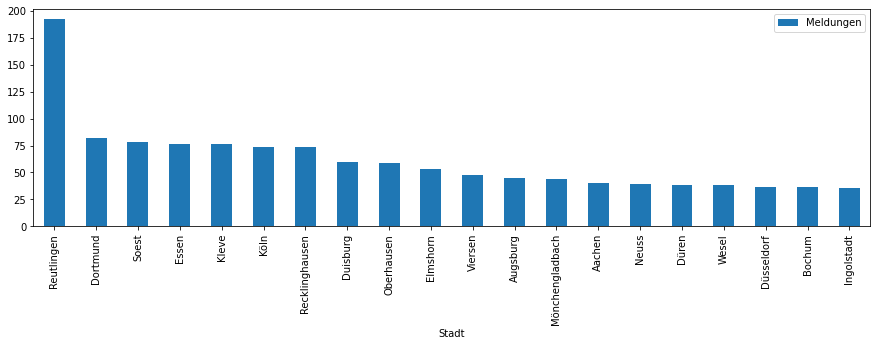

In [85]:
staedte_geoc.sort_values("Meldungen",ascending=False).head(20).plot(x="Stadt", y="Meldungen",kind="bar",figsize=(15,4))

Die Geokodierung erfolgt mithilfe der Bibliothek [GeoPy](https://geopy.readthedocs.io/en/stable/), mithilfe welcher verschiedene Geocoder angesprochen werden können. In diesem Fall verwenden wir Nominatim für OpenStreetMap Daten.

In [105]:
locator = Nominatim(user_agent="nina")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

staedte_geoc["Location"] = staedte_geoc["Stadt"].apply(geocode)

Die Spalte *Location* wird in zwei Spalten, welche Breitengrad (*Latitude*) und Längengrad (*Longitude*) enthalten, aufgesplittet.

In [106]:
staedte_geoc[["Latitude", "Longitude"]] = pd.DataFrame(staedte_geoc["Location"].apply(lambda x: tuple(x.point)[:2]).to_list(), index = staedte_geoc.index)

In [107]:
staedte_geoc.head()

,Stadt,Meldungen,Location,Latitude,Longitude
0,Aachen,40,"(Aachen, Städteregion Aachen, Nordrhein-Westfa...",50.776351,6.083862
1,Ansbach,3,"(Ansbach, Bayern, 91522, Deutschland, (49.3028...",49.302861,10.572229
2,Augsburg,45,"(Augsburg, Bayern, 86150, Deutschland, (48.366...",48.366804,10.898697
3,Bad Salzuflen,7,"(Bad Salzuflen, Kreis Lippe, Nordrhein-Westfal...",52.085745,8.753442
4,Bamberg,9,"(Bamberg, Bayern, Deutschland, (49.8916044, 10...",49.891604,10.886848


Es konnten alle Städte verortet werden.

In [108]:
staedte_geoc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Stadt      137 non-null    object 
 1   Meldungen  137 non-null    int64  
 2   Location   137 non-null    object 
 3   Latitude   137 non-null    float64
 4   Longitude  137 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.5+ KB


### Kartendarstellung
Mit [Folium](https://python-visualization.github.io/folium/) erhält man leicht eine Übersicht der Städte, welche Alarmeldungen ausgelöst haben:

In [109]:
m = folium.Map(location=[50.7, 10.7], zoom_start=6)
staedte_geoc.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]],popup = row["Stadt"],radius=7).add_to(m), axis=1)
m

Wir können die Alarmmeldungen auch mithilfe einer Heatmap darstellen: Es wird heißer, wenn mehr Alarmmeldungen auf engem Raum ausgelöst wurden. Die Heatmap macht hier also eine Aussage über Alarm-Hotspots. Die Häufigkeit von Alarm an einer Lokation lässt sich nicht anhand der Farbe ablesen. Hierzu kann auf einen Kreis geklickt werden: Dann erscheint die Stadt und die Anzahl der Meldungen in dieser.

In [111]:
m = folium.Map(location=[50.7, 10.7], zoom_start=6)

staedte_geoc.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]],popup = row["Stadt"] + ", Meldungen: " + str(row["Meldungen"]),radius=7).add_to(m), axis=1)
heat_data = [[row['Latitude'],row['Longitude'], row["Meldungen"]] for index, row in staedte_geoc.iterrows()]

plugins.HeatMap(heat_data).add_to(m)
m

### Warnkategorie
Für die beiden letzten Jahre 2019 und 2020 enthalten die Daten eine Kategorie.

Der häufigste Alarmgrund war Feuer, danach Meldungen zu Versorgung und Infrastruktur. Ein Alarm aufgrund CBRN deutet auf eine chemische, biologische, radiologische oder nukleare Gefahr hin. Dies wurde 26 Mal gemeldet.

In [118]:
df.groupby("Kategorie").count()["Jahr"].sort_values(ascending=False)

Kategorie
Feuer                          762
Versorgung u. Infrastruktur    593
Öffentliche Sicherheit         412
Gesundheit, Mensch u. Tier     180
Übung                           60
Wetterfolgen                    48
CBRN                            26
Transport und Verkehr           19
Wetter                          18
Wasser                          14
Naturgefahren                   11
Transport u. Verkehr             7
Sonstige                         5
Gewalttaten und Angriffe         2
Zivilschutz und Sonderfälle      1
Name: Jahr, dtype: int64

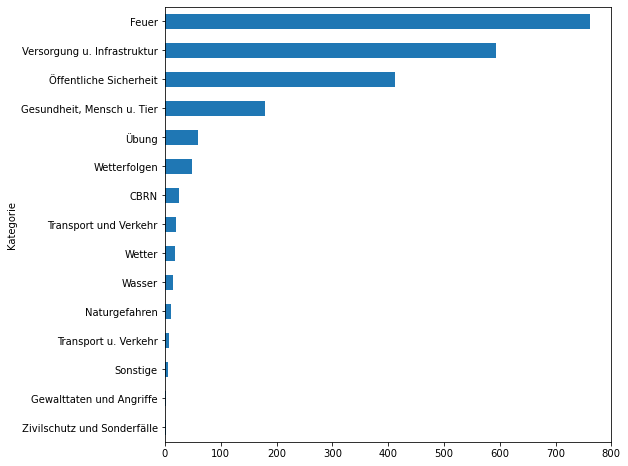

In [125]:
df.groupby("Kategorie").count()["Jahr"].sort_values().plot(kind="barh",figsize=(8,8))

### Warnstufe
Die Daten enthalten eine Warnstufe pro Meldung. Eine Meldung kann Stufe 1, 2 oder 3 haben.

Am häufigsten wurde die Stufe 3 vergeben.

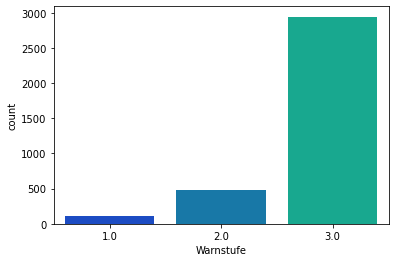

In [234]:
sns.countplot(x="Warnstufe",data=df,palette="winter")

Der Anteil der einzelnen Warnstufen über die Jahre bleibt stabil. Nur in 2016 hat die Warnstufe 2 einen etwas höheren Anteil als üblich.

In [201]:
per_year = pd.DataFrame(df.groupby(["Jahr","Warnstufe"]).count()["Datum"] / df.groupby("Jahr").count()["Warnstufe"]).reset_index().rename(columns = {0 : "Anteil"})

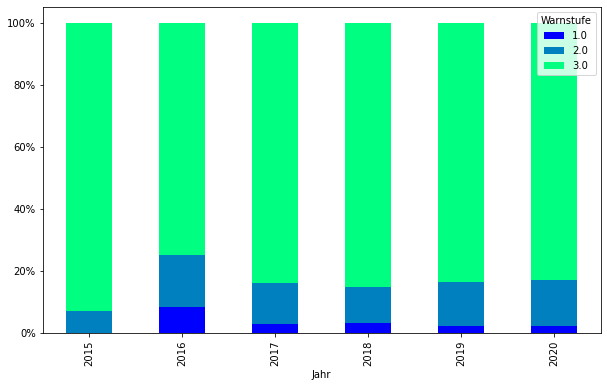

In [245]:
ax = per_year.pivot("Jahr","Warnstufe","Anteil").plot(kind="bar",stacked=True,colormap="winter",figsize=(10,6))
y = ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])